In [179]:
import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
import math

In [180]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import time

def GAIA_query(ra,dec,mag_limit):
    job = Gaia.launch_job_async("SELECT *     FROM gaiadr3.gaia_source     WHERE CONTAINS(POINT(gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE("+str(ra)+","+str(dec)+","+str(10/60)+"))=1     AND phot_g_mean_mag IS NOT NULL     AND parallax IS NOT NULL     ORDER BY phot_g_mean_mag ASC;", dump_to_file=False)

    GAIA_data = job.get_results()
    
    ra=[]
    dec=[]
    mag=[]
    
    for i in range(0,len(GAIA_data)):
        if GAIA_data['phot_g_mean_mag'][i]<=mag_limit:
            mag.append(GAIA_data['phot_g_mean_mag'][i])
            ra.append(GAIA_data['ra'][i])
            dec.append(GAIA_data['dec'][i])

    scales=[] #Need scale values for the marker size of each star to illustrate magnitude on a plot

    for i in mag: #Scale is linear with magnitude from {16}, i.e mag {12} star has marker size {2} times larger than a mag {14} star.
        I=(mag_limit-i)
        scales.append(I*10)

    stars_data={}
    stars_data['ra']=ra
    stars_data['dec']=dec
    stars_data['mag']=mag
    stars_data['scales']=scales
    stars_data['mag_limit']=mag_limit

    return stars_data

stars_data=GAIA_query(54.1,-27.8,18)


INFO: Query finished. [astroquery.utils.tap.core]


In [285]:
class FOV_stars: #Class for the FOV simulation
    def __init__(self,stars_data):
        self.stars_data=stars_data 

        self.inner_annulus_D=7.4 
        self.inner_circle_D=5 
        self.outer_annulus_D=10 

        self.LGS_radial_D=7.4/2 
        self.LGS_D=2.2

        self.PFS_arm_width=0.5
        self.PFS_arm_length=0.5 
        self.PFS_arm_min_angle=45 
        self.PFS_stars_min_mag=15.5

        self.NGS_stars_min_sep=1 
        self.NGS_stars_min_mag=17 

    def orthographic(self,ra,dec,ra0,dec0): 
        x=np.cos(dec)*np.sin(ra-ra0)
        y=np.cos(dec0)*np.sin(dec)-np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)
        return x,y

    def distance(self,A,B=[0,0]):
        d=np.sqrt((A[0]-B[0])**2+(A[1]-B[1])**2)
        return d  
    
    def line(self,A,B):
        m=(A[1]-B[1])/(A[0]-B[0])
        c=A[1]-m*A[0] 
        return m,c

    def perp_line(self,m,c,C): 
        m_perp=-1/m
        c_perp=C[1]-m_perp*C[0]
        return m_perp,c_perp   
   
    def convert_stars_to_xy(self,ra0_rad,dec0_rad):
        x=[]
        y=[] 

        for i in range(0,len(self.stars_data['ra'])): 
            xval,yval=self.orthographic(np.radians(self.stars_data['ra'][i]),np.radians(self.stars_data['dec'][i]),ra0_rad,dec0_rad) 
            x.append(xval)
            y.append(yval)

        void,self.arcmin_in_xy=self.orthographic(ra0_rad,dec0_rad+np.radians(1/60),ra0_rad,dec0_rad)
        self.outer_annulus_xyR=self.outer_annulus_D/2*self.arcmin_in_xy 
        self.inner_annulus_xyR=self.inner_annulus_D/2*self.arcmin_in_xy
        self.inner_circle_xyR=self.inner_circle_D/2*self.arcmin_in_xy 
       
        self.stars_data['x']=x 
        self.stars_data['y']=y

        return

    def find_stars_zones(self,x_offset=0,y_offset=0):
        inner_circle_index= [] 
        inner_annulus_index = []
        outer_annulus_index = [] 

        for i in range(0,len(self.stars_data['x'])):
            dist = self.distance([self.stars_data['x'][i]-x_offset,self.stars_data['y'][i]-y_offset])
            if  dist < self.outer_annulus_xyR: 
                if dist < self.inner_annulus_xyR: 
                    if dist < self.inner_circle_xyR: 
                        inner_circle_index.append(i) 
                    else: 
                        inner_annulus_index.append(i) 
                else:
                    outer_annulus_index.append(i) 

        self.inner_circle_index=inner_circle_index
        self.inner_annulus_index=inner_annulus_index
        self.outer_annulus_index=outer_annulus_index 
        self.NGS_options_index=inner_circle_index+inner_annulus_index
        return

    def find_PFS(self):
        PFS_arm_xywidth=self.PFS_arm_width*self.arcmin_in_xy 
        PFS_arm_xylength=self.PFS_arm_length*self.arcmin_in_xy 

        self.PFS_arm_corners=[]
        self.PFS_arm_lines=[]

        PFS_options_index=self.outer_annulus_index+self.inner_annulus_index
        PFS_options_mag=[]

        for i in PFS_options_index.copy():
            if self.stars_data['mag'][i] < self.PFS_stars_min_mag:
                PFS_options_mag.append(self.stars_data['mag'][i])
            else:
                PFS_options_index.remove(i)

        if PFS_options_index==[]:
            self.PFS_stars_index=[]
            self.PFS_obscured_index=[]
            return 
            
        PFS_options_mag,PFS_options_index = zip(*sorted(zip(PFS_options_mag,PFS_options_index)))
        PFS_options_index=list(PFS_options_index)
        
        PFS_stars_index=[]
        PFS_stars_angles=[]

        count=0
        for i in PFS_options_index:
            theta=math.atan2(self.stars_data['x'][i],self.stars_data['y'][i])
            if all(abs(theta-val) > np.radians(self.PFS_arm_min_angle) for val in PFS_stars_angles):
                PFS_stars_index.append(i)
                PFS_stars_angles.append(theta)
                if i in self.NGS_options_index:
                    self.NGS_options_index.remove(i)

                A=(self.stars_data['x'][i]-PFS_arm_xylength*np.sin(theta)+PFS_arm_xywidth*np.cos(theta),
                self.stars_data['y'][i]-PFS_arm_xylength*np.cos(theta)-PFS_arm_xywidth*np.sin(theta))
                B=(self.stars_data['x'][i]-PFS_arm_xylength*np.sin(theta)-PFS_arm_xywidth*np.cos(theta),
                self.stars_data['y'][i]-PFS_arm_xylength*np.cos(theta)+PFS_arm_xywidth*np.sin(theta))

                AB_m,AB_c=self.line(A,B)
                AD_m,AD_c=self.perp_line(AB_m,AB_c,A)
                BC_m,BC_c=self.perp_line(AB_m,AB_c,B)
                self.PFS_arm_lines.append([[AB_m,AB_c],[AD_m,AD_c],[BC_m,BC_c]])

                if np.pi/2>theta>-np.pi/2: 
                    C=((self.outer_annulus_xyR-BC_c)/BC_m,self.outer_annulus_xyR)
                    D=((self.outer_annulus_xyR-AD_c)/AD_m,self.outer_annulus_xyR) 
                else:
                    C=((-self.outer_annulus_xyR-BC_c)/BC_m,-self.outer_annulus_xyR)
                    D=((-self.outer_annulus_xyR-AD_c)/AD_m,-self.outer_annulus_xyR)   

                self.PFS_arm_corners.append([A,B,C,D])
                count=count+1
            
            if count==3:
                break

        self.PFS_stars_angles=PFS_stars_angles
        PFS_obscured_index=[]

        for i in (self.inner_circle_index.copy()+self.inner_annulus_index.copy()+self.outer_annulus_index.copy()):
            starx=self.stars_data['x'][i]
            stary=self.stars_data['y'][i]
            for o in range(0,count):
                theta=PFS_stars_angles[o]
                AB_m,AB_c=self.PFS_arm_lines[o][0]
                AD_m,AD_c=self.PFS_arm_lines[o][1]
                BC_m,BC_c=self.PFS_arm_lines[o][2]   

                if 0>theta>-np.pi/2 and stary>AB_m*starx+AB_c and stary<AD_m*starx+AD_c and stary>BC_m*starx+BC_c:
                        PFS_obscured_index.append(i)
                        if i in self.NGS_options_index:
                            self.NGS_options_index.remove(i)
                elif -np.pi/2>theta>-np.pi and stary<AB_m*starx+AB_c and stary<AD_m*starx+AD_c and stary>BC_m*starx+BC_c:
                        PFS_obscured_index.append(i)
                        if i in self.NGS_options_index:
                            self.NGS_options_index.remove(i)
                elif np.pi>theta>np.pi/2 and stary<AB_m*starx+AB_c and stary>AD_m*starx+AD_c and stary<BC_m*starx+BC_c:
                        PFS_obscured_index.append(i)
                        if i in self.NGS_options_index:
                            self.NGS_options_index.remove(i)
                elif np.pi/2>theta>0 and stary>AB_m*starx+AB_c and stary>AD_m*starx+AD_c and stary<BC_m*starx+BC_c:
                        PFS_obscured_index.append(i)
                        if i in self.NGS_options_index:
                            self.NGS_options_index.remove(i)

        self.PFS_stars_index=PFS_stars_index
        self.PFS_obscured_index=PFS_obscured_index
    
    def find_LGS(self,LGS_angle):
        LGS_radial_xyD=self.LGS_radial_D*self.arcmin_in_xy
        LGS_xyR=self.LGS_D/2*self.arcmin_in_xy

        LGS_pos=[[LGS_radial_xyD*np.sin(LGS_angle),LGS_radial_xyD*np.cos(LGS_angle)],[LGS_radial_xyD*np.sin(LGS_angle+np.pi/2),LGS_radial_xyD*np.cos(LGS_angle+np.pi/2)],
                [LGS_radial_xyD*np.sin(LGS_angle+np.pi),LGS_radial_xyD*np.cos(LGS_angle+np.pi)],[LGS_radial_xyD*np.sin(LGS_angle+3*np.pi/2),LGS_radial_xyD*np.cos(LGS_angle+3*np.pi/2)]]

        LGS_obscured_index=[]
        
        for i in (self.inner_circle_index.copy()+self.inner_annulus_index.copy()+self.outer_annulus_index.copy()):

            for o in range(0,4):
                if (self.stars_data['x'][i]-LGS_pos[o][0])**2+(self.stars_data['y'][i]-LGS_pos[o][1])**2<(LGS_xyR)**2:
                    LGS_obscured_index.append(i)
                    if i in self.NGS_options_index:
                        self.NGS_options_index.remove(i)
                            
        self.LGS_pos=LGS_pos
        self.LGS_obscured_index=LGS_obscured_index
        self.LGS_xyR=LGS_xyR

    def find_NGS(self):
        NGS_stars_index=[]
        NGS_options_mag=[]

        if self.NGS_options_index == []:
            self.NGS_stars_index=[]
            return

        for i in self.NGS_options_index.copy():
            if self.stars_data['mag'][i] > self.NGS_stars_min_mag:
                self.NGS_options_index.remove(i)
            else:
                NGS_options_mag.append(self.stars_data['mag'][i])
        
        NGS_options_mag, self.NGS_options_index = zip(*sorted(zip(NGS_options_mag,self.NGS_options_index)))

        self.NGS_options_index=list(self.NGS_options_index) 

        NGS_stars_index=[self.NGS_options_index[0]]
        for i in range(1,len(self.NGS_options_index)):
            if abs(self.distance([self.stars_data['x'][NGS_stars_index[0]]-self.stars_data['x'][self.NGS_options_index[i]],self.stars_data['y'][NGS_stars_index[0]]-self.stars_data['y'][self.NGS_options_index[i]]],[0,0]))>self.NGS_stars_min_sep*self.arcmin_in_xy: #SCALE!!!
                NGS_stars_index.append(self.NGS_options_index[i])
                break

        for o in range(i,len(self.NGS_options_index)):
            if (abs(self.distance([self.stars_data['x'][NGS_stars_index[0]]-self.stars_data['x'][self.NGS_options_index[o]],self.stars_data['y'][NGS_stars_index[0]]-self.stars_data['y'][self.NGS_options_index[o]]],[0,0]))>self.NGS_stars_min_sep*self.arcmin_in_xy
            and abs(self.distance([self.stars_data['x'][NGS_stars_index[1]]-self.stars_data['x'][self.NGS_options_index[o]],self.stars_data['y'][NGS_stars_index[1]]-self.stars_data['y'][self.NGS_options_index[o]]],[0,0]))>self.NGS_stars_min_sep*self.arcmin_in_xy):
                NGS_stars_index.append(self.NGS_options_index[o])
                break                

        self.NGS_stars_index=NGS_stars_index

        if len(NGS_stars_index)==3:
            a,b,c=NGS_stars_index[0],NGS_stars_index[1],NGS_stars_index[2]
            self.NGS_area=abs((self.stars_data['x'][a]*self.stars_data['y'][b]+self.stars_data['x'][b]*self.stars_data['y'][c]+self.stars_data['x'][c]*self.stars_data['y'][a]
                                -self.stars_data['y'][a]*self.stars_data['x'][b]-self.stars_data['y'][b]*self.stars_data['x'][c]-self.stars_data['y'][c]*self.stars_data['x'][a])/(2*self.arcmin_in_xy**2))
            self.NGS_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b]+self.stars_data['x'][c])/(3*self.arcmin_in_xy),(self.stars_data['y'][a]+self.stars_data['y'][b]+self.stars_data['y'][c])/(3*self.arcmin_in_xy)]  
            self.NGS_barycentre_D=np.sqrt(self.NGS_barycentre[0]**2+self.NGS_barycentre[1]**2)
        if len(NGS_stars_index)==2:
            a,b=NGS_stars_index[0],NGS_stars_index[1]
            self.NGS_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b])/(2*self.arcmin_in_xy),(self.stars_data['y'][a]+self.stars_data['y'][b])/(2*self.arcmin_in_xy)]
            self.NGS_barycentre_D=np.sqrt(self.NGS_barycentre[0]**2+self.NGS_barycentre[1]**2)
        if len(NGS_stars_index)==1:
            a=NGS_stars_index[0]
            self.NGS_barycentre=[self.stars_data['x'][a],self.stars_data['y'][a]]
            self.NGS_barycentre_D=np.sqrt(self.NGS_barycentre[0]**2+self.NGS_barycentre[1]**2)

    def find_PFS_LGS_overlap(self):
        PFS_stars=self.PFS_stars_index
        LGS_xyR=self.LGS_xyR
        intercepts=[[],[],[]]
        intercepts_footprints=[None,None,None]
        overlap_areas=[0,0,0]

        for PFS in range(0,len(PFS_stars)):
            theta=self.PFS_stars_angles[PFS]
            for LGS in range(0,4):
                p,q=self.LGS_pos[LGS][0],self.LGS_pos[LGS][1]
                for arm in range(0,3):
                    m,c=self.PFS_arm_lines[PFS][arm][0],self.PFS_arm_lines[PFS][arm][1]
                    a,b,c2=1+m**2,2*(m*c-m*q-p),p**2-LGS_xyR**2+c**2+q**2-2*c*q
                    det=b**2-4*a*c2

                    if det > 0:
                        x_vals=[(-b+np.sqrt(det))/(2*a),(-b-np.sqrt(det))/(2*a)]
                        
                        for x_val in x_vals:

                            if arm == 1 or arm ==2:
                                if theta < 0 and x_val < self.PFS_arm_corners[PFS][arm-1][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS
                                if theta > 0 and x_val > self.PFS_arm_corners[PFS][arm-1][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS
                            else:
                                if np.pi/2>theta>-np.pi/2 and self.PFS_arm_corners[PFS][0][0] > x_val > self.PFS_arm_corners[PFS][1][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS
                                if (theta < -np.pi/2 or theta > np.pi/2) and self.PFS_arm_corners[PFS][1][0] > x_val > self.PFS_arm_corners[PFS][0][0]:
                                        y_intercept=m*x_val+c
                                        intercepts[PFS].append([x_val,y_intercept])
                                        intercepts_footprints[PFS]=LGS

        for count, intercept in enumerate(intercepts):
            corners_inside=0
            if intercept != []:
                A,B=self.PFS_arm_corners[count][0],self.PFS_arm_corners[count][1]
                footprint=intercepts_footprints[count]
                LGS_x,LGS_y=self.LGS_pos[footprint][0],self.LGS_pos[footprint][1]

                if (A[0]-LGS_x)**2+(A[1]-LGS_y)**2<LGS_xyR**2:
                    corners_inside=corners_inside+1
                    E_x,E_y=A[0]-LGS_x,A[1]-LGS_y
                if (B[0]-LGS_x)**2+(B[1]-LGS_y)**2<LGS_xyR**2: 
                    corners_inside=corners_inside+1 
                    E_x,E_y=B[0]-LGS_x,B[1]-LGS_y 

                if len(intercept)==4:
                    I0_x,I1_x,I2_x,I3_x=intercept[0][0]-LGS_x,intercept[1][0]-LGS_x,intercept[2][0]-LGS_x,intercept[3][0]-LGS_x
                    I0_y,I1_y,I2_y,I3_y=intercept[0][1]-LGS_y,intercept[1][1]-LGS_y,intercept[2][1]-LGS_y,intercept[3][1]-LGS_y

                    if corners_inside==0:
                        theta02=abs(np.arccos(np.dot([I0_x,I0_y],[I2_x,I2_y])/(np.sqrt(I0_x**2+I0_y**2)*np.sqrt(I2_x**2+I2_y**2))))
                        theta13=abs(np.arccos(np.dot([I1_x,I1_y],[I3_x,I3_y])/(np.sqrt(I1_x**2+I1_y**2)*np.sqrt(I3_x**2+I3_y**2))))
                        x,y=[I0_x,I1_x,I3_x,I2_x],[I0_y,I1_y,I3_y,I2_y]
                        I1I2I3I4=abs(0.5*(x[0]*y[1]+x[1]*y[2]+x[2]*y[3]+x[3]*y[0]-y[0]*x[1]-y[1]*x[2]-y[2]*x[3]-y[3]*x[0])) #Area of the quadrilateral, using shoelace formula
                        OI0I2_sector,OI1I3_sector=LGS_xyR**2*theta02/2,LGS_xyR**2*theta13/2
                        OI0I2_triangle,OI1I3_triangle=abs((I0_x*I2_y-I0_y*I2_x)/2),abs((I3_x*I1_y-I3_y*I1_x)/2)
                        overlap_areas[count]=abs((I1I2I3I4+OI0I2_sector+OI1I3_sector-OI0I2_triangle-OI1I3_triangle)/(self.arcmin_in_xy**2))

                    if corners_inside==1:
                        points=[[E_x,E_y],[I0_x,I0_y],[I1_x,I1_y],[I2_x,I2_y],[I3_x,I3_y]]
                        avg_x,avg_y=(E_x+I0_x+I1_x+I2_x+I3_x)/5,(E_y+I0_y+I1_y+I2_y+I3_y)/5

                        phi = []
                        for i in points:
                            phi.append(math.atan2(i[0]-avg_x,i[1]-avg_y))
                        phi,points =zip(*sorted(zip(phi,points)))
                        phi,points=list(phi),list(points)
                        E_index  = [index for (index, item) in enumerate(points) if item == [E_x,E_y]][0]
                        E,U1,U2,U3,U4=points[E_index],points[E_index-1],points[E_index-2],points[E_index-3],points[E_index-4]

                        thetaU12=abs(np.arccos(np.dot([U1[0],U1[1]],[U2[0],U2[1]])/(np.sqrt(U1[0]**2+U1[1]**2)*np.sqrt(U2[0]**2+U2[1]**2))))
                        thetaU34=abs(np.arccos(np.dot([U3[0],U3[1]],[U4[0],U4[1]])/(np.sqrt(U3[0]**2+U3[1]**2)*np.sqrt(U4[0]**2+U4[1]**2))))     
                        points_area = abs((E[0]*U1[1]+U1[0]*U2[1]+U2[0]*U3[1]+U3[0]*U4[1]+U4[0]*E[1]-E[1]*U1[0]-U1[1]*U2[0]-U2[1]*U3[0]-U3[1]*U4[0]-U4[1]*E[0])/2)
                        OU1U2_sector,OU3U4_sector=(1/2)*LGS_xyR**2*thetaU12,(1/2)*LGS_xyR**2*thetaU34
                        OU1U2_triangle,OU3U4_triangle=abs((U1[0]*U2[1]-U1[1]*U2[0])/2),abs((U3[0]*U4[1]-U3[1]*U4[0])/2)     
                        overlap_areas[count]=abs((points_area+OU1U2_sector+OU3U4_sector-OU1U2_triangle-OU3U4_triangle)/(self.arcmin_in_xy**2)) 

                elif len(intercept)==2:
                    I0_x,I0_y=intercept[0][0]-LGS_x,intercept[0][1]-LGS_y
                    I1_x,I1_y=intercept[1][0]-LGS_x,intercept[1][1]-LGS_y 
                    theta=abs(np.arccos(np.dot([I0_x,I0_y],[I1_x,I1_y])/(np.sqrt(I0_x**2+I0_y**2)*np.sqrt(I1_x**2+I1_y**2))))

                    if corners_inside==2:
                        OI0I1_sector=LGS_xyR**2*theta/2
                        OI0I1_triangle=abs((I0_x*I1_y-I0_y*I1_x)/2)
                        x,y=[A[0]-LGS_x,B[0]-LGS_x,I1_x,I0_x],[A[1]-LGS_y,B[1]-LGS_y,I1_y,I0_y]
                        ABI0I1=abs(0.5*(x[0]*y[1]+x[1]*y[2]+x[2]*y[3]+x[3]*y[0]-y[0]*x[1]-y[1]*x[2]-y[2]*x[3]-y[3]*x[0])) 
                        overlap_areas[count]=abs((OI0I1_sector-OI0I1_triangle+ABI0I1)/(self.arcmin_in_xy**2))

                    if corners_inside==1:
                        OI0I1_sector=LGS_xyR**2*theta/2
                        OI0I1_triangle=abs((I0_x*I1_y-I0_y*I1_x)/2) 
                        EI0I1_triangle=abs((I0_x*I1_y+I1_x*E_y+E_x*I0_y-I0_y*I1_x-I1_y*E_x-E_y*I0_x)/2)
                        overlap_areas[count]=abs((OI0I1_sector-OI0I1_triangle+EI0I1_triangle)/(self.arcmin_in_xy**2))

                    if corners_inside==0:
                        OI0I1_sector=LGS_xyR**2*theta/2
                        OI0I1_triangle=abs((I0_x*I1_y-I0_y*I1_x)/2)
                        overlap_areas[count]=abs((OI0I1_sector-OI0I1_triangle)/(self.arcmin_in_xy**2))

                elif len(intercept)==6:
                    print("Fudge")
                    #Needs fixing
                    
        self.overlap_area=overlap_areas
        self.overlap_footprint=intercepts_footprints
        self.intercepts=intercepts
        return overlap_areas

    def plot(self):
        fig, ax = plt.subplots(figsize=(10,10))
        FOV_techfield = plt.Circle((0,0),self.outer_annulus_xyR, color='gray', alpha=0.4) #Technical field FOV
        FOV_sciencefield = plt.Circle((0,0),self.inner_annulus_xyR, color='orange', alpha=0.4) #Science field FOV
        FOV_PFSboundary = plt.Circle((0,0),self.inner_circle_xyR,color='black',fill=False,alpha=0.4)
        ax.add_patch(FOV_techfield)
        ax.add_patch(FOV_sciencefield)
        ax.add_patch(FOV_PFSboundary)  
        plt.scatter(0,0,marker='+',color='black')     

        for i in range(0,4):
            ax.annotate("LGS {}".format(i+1),(self.LGS_pos[i][0],self.LGS_pos[i][1]))   
        for i in range(0,4):
            LGS=plt.Circle((self.LGS_pos[i][0],self.LGS_pos[i][1]),self.LGS_xyR, color='red', alpha=0.2)
            ax.add_patch(LGS)
        
        for i in range(0,len(self.stars_data['mag'])):
            if i in self.NGS_stars_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='blue',s=self.stars_data['scales'][i])
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")
            elif i in self.NGS_options_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='green',s=self.stars_data['scales'][i])
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")
            elif i in self.PFS_stars_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='black',s=self.stars_data['scales'][i])
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")
            elif i in self.PFS_obscured_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scales'][i])
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")
            elif i in self.LGS_obscured_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scales'][i])
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")
            elif i in self.outer_annulus_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='brown',s=self.stars_data['scales'][i])
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")
            elif i in self.inner_annulus_index + self.inner_circle_index:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='grey',s=self.stars_data['scales'][i])
                ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")

        for i in range(0,len(self.PFS_stars_index)):
            plt.plot([self.PFS_arm_corners[i][0][0],self.PFS_arm_corners[i][1][0]],[self.PFS_arm_corners[i][0][1],self.PFS_arm_corners[i][1][1]],color='red')
            plt.plot([self.PFS_arm_corners[i][0][0],self.PFS_arm_corners[i][3][0]],[self.PFS_arm_corners[i][0][1],self.PFS_arm_corners[i][3][1]],color='red')
            plt.plot([self.PFS_arm_corners[i][1][0],self.PFS_arm_corners[i][2][0]],[self.PFS_arm_corners[i][1][1],self.PFS_arm_corners[i][2][1]],color='red')   
        for count,i in enumerate(self.intercepts):
            for o in i:
                plt.scatter(o[0],o[1],color='black',marker='x')
            if self.overlap_footprint[count] != None:
                print("PFS and LGS {} overlap = {:.2f} arcmin^2".format(self.overlap_footprint[count]+1,self.overlap_area[count]))

        if len(self.NGS_stars_index)==3:        
            a,b,c=self.NGS_stars_index[0],self.NGS_stars_index[1],self.NGS_stars_index[2]
            plt.plot([self.stars_data['x'][a],self.stars_data['x'][b]],[self.stars_data['y'][a],self.stars_data['y'][b]],color='blue')
            plt.plot([self.stars_data['x'][b],self.stars_data['x'][c]],[self.stars_data['y'][b],self.stars_data['y'][c]],color='blue')
            plt.plot([self.stars_data['x'][c],self.stars_data['x'][a]],[self.stars_data['y'][c],self.stars_data['y'][a]],color='blue')
            plt.scatter(self.NGS_barycentre[0]*self.arcmin_in_xy,self.NGS_barycentre[1]*self.arcmin_in_xy,marker='x',color='blue') 
            print("NGS Barycentre Radial Distance = {:.3} arcmin".format(self.NGS_barycentre_D))
            print("NGS Area = {:.3} arcmin^2".format(self.NGS_area))

        plt.ylim(-self.outer_annulus_xyR,self.outer_annulus_xyR)
        plt.xlim(-self.outer_annulus_xyR,self.outer_annulus_xyR)
        ticks = np.linspace(-self.outer_annulus_xyR,+self.outer_annulus_xyR,21)
        ticks_labels = np.linspace(-5,5,21)
        plt.yticks(ticks)
        plt.xticks(ticks)
        ax.set_xticklabels(ticks_labels)
        ax.set_yticklabels(ticks_labels)
        plt.ylabel("arcmin")
        plt.xlabel("arcmin")
        plt.gca().invert_xaxis()

    def run(self,ra_0,dec_0,LGS_angle):
        start=time.time()
        self.convert_stars_to_xy(np.radians(ra_0),np.radians(dec_0))
        self.find_stars_zones()
        self.find_PFS()
        self.find_LGS(np.radians(LGS_angle))
        self.find_NGS()
        self.find_PFS_LGS_overlap()
        print(time.time()-start)
        self.plot()

INFO: Query finished. [astroquery.utils.tap.core]
Fudge
0.002209901809692383
PFS and LGS 3 overlap = 0.00 arcmin^2
PFS and LGS 2 overlap = 0.54 arcmin^2
NGS Barycentre Radial Distance = 1.86 arcmin
NGS Area = 1.54 arcmin^2


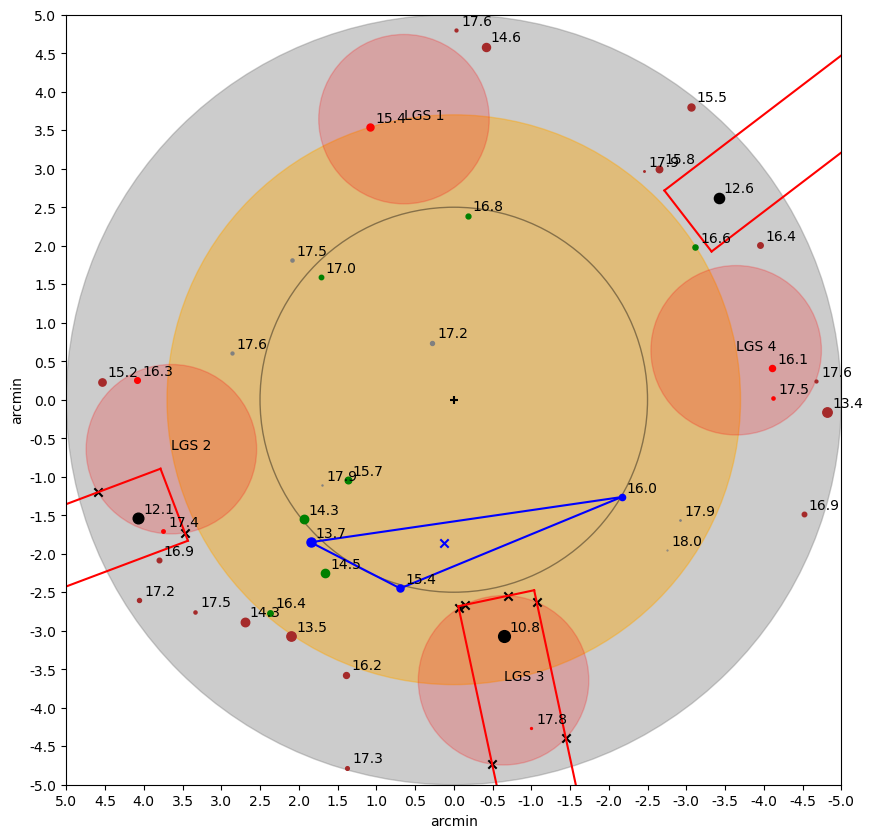

In [286]:
stars_data=GAIA_query(30,30,18)
a=FOV_stars(stars_data)
a.run(30,30,LGS_angle=10)

INFO: Query finished. [astroquery.utils.tap.core]
0.0012950897216796875
PFS and LGS 2 overlap = 0.50 arcmin^2
PFS and LGS 1 overlap = 0.05 arcmin^2
NGS Barycentre Radial Distance = 1.22 arcmin
NGS Area = 3.94 arcmin^2


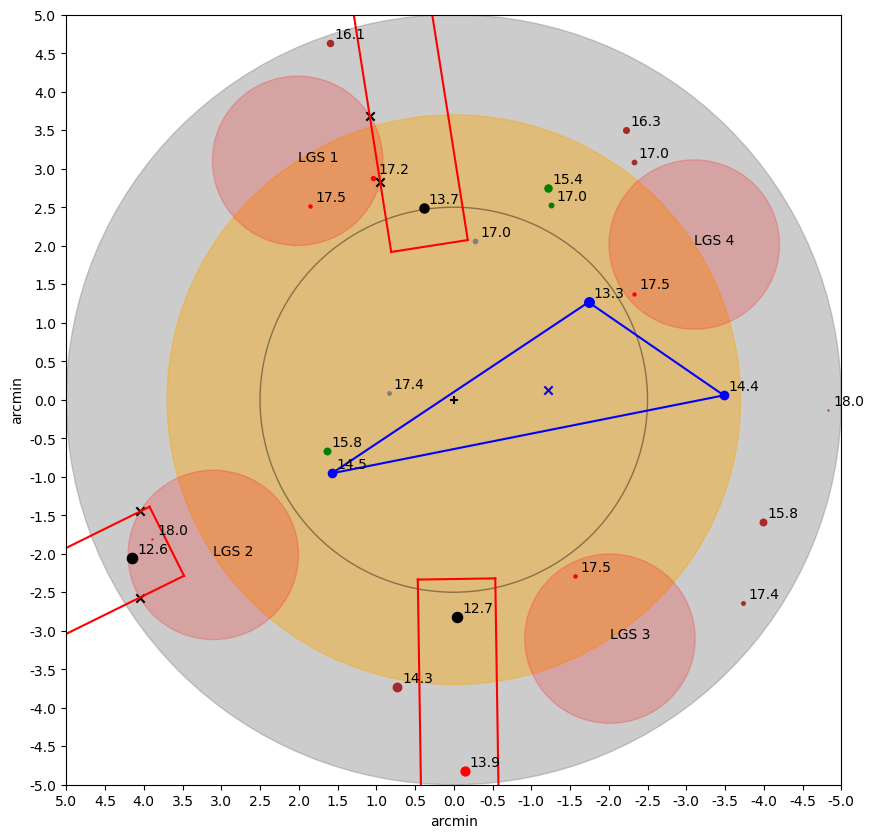

In [255]:
stars_data=GAIA_query(54.1,-27.8,18)
a=FOV_stars(stars_data)
start=time.time()
a.convert_stars_to_xy(np.radians(54.1),np.radians(-27.8))
a.find_stars_zones()
a.find_PFS()
a.find_LGS(np.radians(33))
a.find_NGS()
a.find_PFS_LGS_overlap()
print(time.time()-start)
a.plot()


INFO: Query finished. [astroquery.utils.tap.core]
0.0012106895446777344
PFS and LGS 2 overlap = 0.42 arcmin^2
PFS and LGS 3 overlap = 0.67 arcmin^2
PFS and LGS 1 overlap = 1.71 arcmin^2
NGS Barycentre Radial Distance = 1.12 arcmin
NGS Area = 3.04 arcmin^2


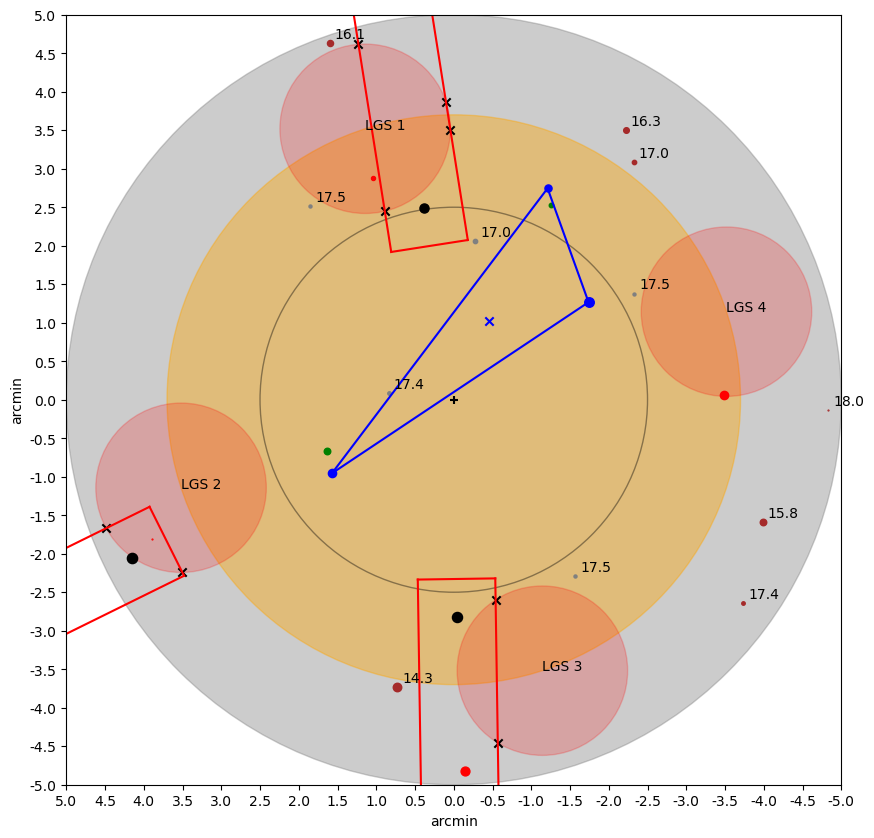

In [231]:
stars_data=GAIA_query(54.1,-27.8,18)
a=FOV_stars(stars_data)
a.run(54.1,-27.8, LGS_angle=18)


In [218]:
stars_data=GAIA_query(30,30,18)

INFO: Query finished. [astroquery.utils.tap.core]


-0.00028080145517985026
PFS and LGS 3 overlap = 1.88 arcmin^2
PFS and LGS 2 overlap = 0.90 arcmin^2
PFS and LGS 4 overlap = 0.13 arcmin^2


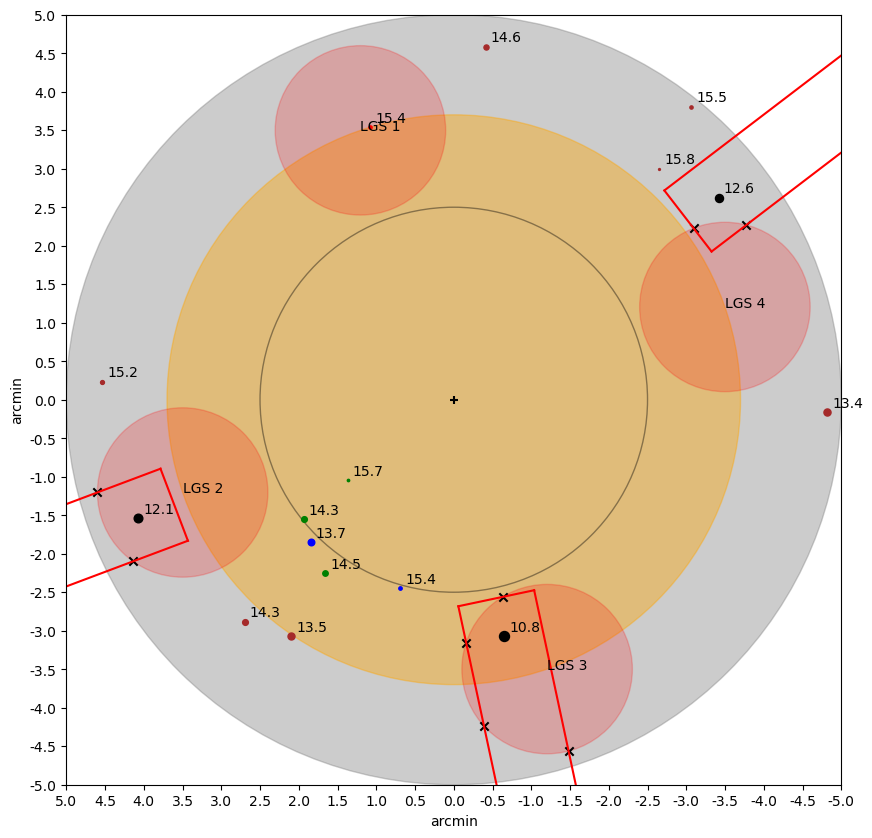

In [268]:
area_1=[]
area_2=[]
area_3=[]
start=time.time()
xrange=np.linspace(0,19,20)
for i in range(0,20):
    a=FOV_stars(stars_data)
    a.convert_stars_to_xy(np.radians(30),np.radians(30))
    a.find_stars_zones()
    a.find_PFS()
    a.find_LGS(np.radians(i))
    a.find_NGS()
    a.find_NGS()
    area=a.find_PFS_LGS_overlap()
    area_1.append(area[0])
    area_2.append(area[1])
    area_3.append(area[2])
print((start-time.time())/90)
a.plot()

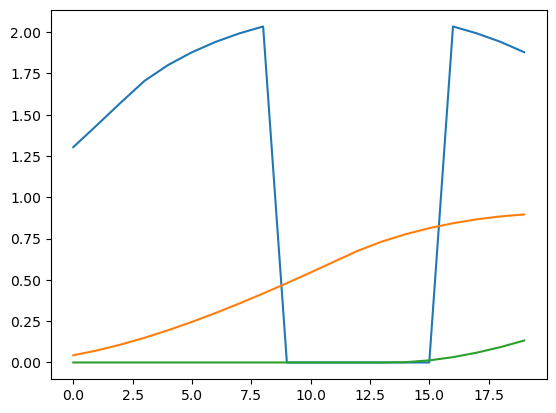

In [269]:
plt.plot(xrange,area_1)
plt.plot(xrange,area_2)
plt.plot(xrange,area_3)


In [33]:
a=[3,5,7,8,3,5]
c=[3]
b=4
if b not in a or c: 
    print(4)

4
